In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats

# Define parameters for easy adjustment
IQR_FACTOR = 1.5

def load_data(file_path):
    """
    Load the dataset from a parquet file.
    """
    df = pd.read_parquet(file_path)
    return df

def remove_missing_target(df):
    """
    Remove rows where the target variable 'Ewltp (g/km)' is missing.
    """
    initial_count = len(df)
    df = df.dropna(subset=['Ewltp (g/km)'])
    dropped = initial_count - len(df)
    print(f"Removed {dropped} rows without the target variable.")
    return df

def exclude_electric_propulsion(df):
    """
    Exclude vehicles with any type of electric propulsion based on fuel type and fuel mode.
    Also exclude hydrogen-fueled vehicles to prevent their categories from being dummy encoded.
    """
    initial_count = len(df)
    
    # Define fuel types and modes indicating electric propulsion
    electric_fuel_types = ['PETROL/ELECTRIC', 'DIESEL/ELECTRIC', 'ELECTRIC']
    electric_fuel_modes = ['E', 'P', 'H']
    
    # Remove rows with electric fuel types
    df = df[~df['Ft'].isin(electric_fuel_types)]
    dropped_ft = initial_count - len(df)
    
    # Update initial count after removing electric fuel types
    initial_count = len(df)
    
    # Remove rows with electric fuel modes
    df = df[~df['Fm'].isin(electric_fuel_modes)]
    dropped_fm = initial_count - len(df)
    
    # Additionally, remove hydrogen-fueled vehicles
    hydrogen_fuel_type = 'HYDROGEN'  # Assuming 'HYDROGEN' is the exact category name
    df = df[~df['Ft'].isin([hydrogen_fuel_type])]
    dropped_hydrogen = (initial_count - dropped_ft - len(df))
    
    total_dropped = dropped_ft + dropped_fm + dropped_hydrogen
    print(f"Excluded {total_dropped} vehicles with electric propulsion and hydrogen fuel type.")
    
    # Ensure 'Ft' and 'Fm' are of categorical type
    df['Ft'] = df['Ft'].astype('category')
    df['Fm'] = df['Fm'].astype('category')
    
    # Remove the electric categories from the categories metadata
    df['Ft'].cat.remove_categories(electric_fuel_types + [hydrogen_fuel_type], inplace=True)
    df['Fm'].cat.remove_categories(electric_fuel_modes, inplace=True)
    
    # Remove any unused categories
    df['Ft'].cat.remove_unused_categories(inplace=True)
    df['Fm'].cat.remove_unused_categories(inplace=True)
    
    return df


def combine_mass_variables(df):
    """
    Use 'Mt' where present; if not, substitute with 'm (kg)'.
    """
    df['Mass (kg)'] = df['Mt'].combine_first(df['m (kg)'])
    df = df.drop(columns=['Mt', 'm (kg)'])
    return df

def drop_missing_values(df, variables):
    """
    Drop rows with missing values in the specified variables.
    """
    total_rows = len(df)
    for var in variables:
        missing = df[var].isnull().sum()
        if missing > 0:
            share_dropped = missing / total_rows
            print(f"Variable '{var}': Dropping {missing} rows ({share_dropped:.2%}) due to missing values.")
    df = df.dropna(subset=variables)
    return df

def remove_outliers(df, numerical_vars, factor=IQR_FACTOR):
    """
    Remove outliers from numerical variables using the IQR method.
    """
    for var in numerical_vars:
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        initial_count = len(df)
        df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
        dropped = initial_count - len(df)
        share_dropped = dropped / initial_count
        if dropped > 0:
            print(f"Variable '{var}': Removed {dropped} outliers ({share_dropped:.2%}).")
    return df

def encode_categorical(df, categorical_vars):
    """
    Apply one-hot encoding to categorical variables and return the list of new columns created.
    """
    # Get the list of columns before encoding
    cols_before_encoding = set(df.columns)
    # Perform encoding
    df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
    # Get the list of new columns generated by encoding
    new_columns = list(set(df.columns) - cols_before_encoding)
    return df, new_columns

def prepare_features(df, target_var, explanatory_vars):
    """
    Prepare the feature matrix X and target vector y.
    """
    # Keep only the explanatory and target variables
    df = df[explanatory_vars + [target_var]]
    
    # Separate features and target
    X = df.drop(columns=[target_var])
    y = df[target_var]
    
    # Ensure all features are numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    y = y.astype(float)
    
    # Drop any rows with NaN values introduced during conversion
    combined = pd.concat([X, y], axis=1)
    combined = combined.dropna()
    
    X = combined.drop(columns=[target_var])
    y = combined[target_var]
    
    return X, y

def calculate_test_statistics(X, y, model):
    """
    Calculate test statistics for the significance of each coefficient.
    """
    # Add intercept term
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X.values))
    params = np.append(model.intercept_, model.coef_)

    predictions = model.predict(X)
    residuals = y - predictions
    residual_sum_of_squares = np.sum(residuals ** 2)
    degrees_of_freedom = X_with_intercept.shape[0] - X_with_intercept.shape[1]
    mse = residual_sum_of_squares / degrees_of_freedom

    # Calculate variance-covariance matrix
    var_b = mse * np.linalg.inv(X_with_intercept.T.dot(X_with_intercept))
    standard_errors = np.sqrt(np.diagonal(var_b))

    t_stats = params / standard_errors
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), degrees_of_freedom)) for t in t_stats]

    return params, standard_errors, t_stats, p_values



In [2]:
def main():
    # Load data
    df = load_data('your_dataset.csv')
    
    # Data Preparation
    df = remove_missing_target(df)
    df = exclude_electric_propulsion(df)
    df = combine_mass_variables(df)
    
    # Select variables
    numerical_vars = ['Mass (kg)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)']
    categorical_vars = ['Ft', 'Fm']
    target_var = 'Ewltp (g/km)'
    
    # Drop missing values in numerical variables before outlier removal
    df = drop_missing_values(df, numerical_vars)
    df = remove_outliers(df, numerical_vars)
    
    # Drop missing values in categorical variables before encoding
    df = drop_missing_values(df, categorical_vars)
    
    # Encode categorical variables and get the list of new columns
    df, encoded_columns = encode_categorical(df, categorical_vars)
    
    # Update explanatory_vars to include encoded categorical variables
    explanatory_vars = numerical_vars + encoded_columns
    
    # Prepare features and target
    X, y = prepare_features(df, target_var, explanatory_vars)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate test statistics
    params, std_errors, t_stats, p_values = calculate_test_statistics(X_train, y_train, model)

    # Prepare results
    feature_names = ['Intercept'] + list(X_train.columns)
    results = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': params,
        'Std Error': std_errors,
        't-Statistic': t_stats,
        'p-Value': p_values
    })

    print("\nRegression Coefficients and Test Statistics:")
    print(results)

In [3]:
# Load data
df = load_data("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2.parquet")

In [4]:
# Data Preparation
df = remove_missing_target(df)
df = exclude_electric_propulsion(df)
df = combine_mass_variables(df)

Removed 3565598 rows without the target variable.
Excluded 2722185 vehicles with electric propulsion and hydrogen fuel type.


C:\Users\onepl\AppData\Local\Temp\ipykernel_18932\3705567692.py:62: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['Ft'].cat.remove_categories(electric_fuel_types + [hydrogen_fuel_type], inplace=True)
C:\Users\onepl\AppData\Local\Temp\ipykernel_18932\3705567692.py:63: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['Fm'].cat.remove_categories(electric_fuel_modes, inplace=True)
C:\Users\onepl\AppData\Local\Temp\ipykernel_18932\3705567692.py:66: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['Ft'].cat.remove_unused_categories(inplace=True)
C:\Users\onepl\AppData\Local\T

In [5]:
# Select variables
numerical_vars = ['Mass (kg)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)']
categorical_vars = ['Ft', 'Fm']
target_var = 'Ewltp (g/km)'
    
# Drop missing values in numerical variables before outlier removal
df = drop_missing_values(df, numerical_vars)
df = remove_outliers(df, numerical_vars)
    
# Drop missing values in categorical variables before encoding
df = drop_missing_values(df, categorical_vars)
  
# Encode categorical variables and get the list of new columns
df, encoded_columns = encode_categorical(df, categorical_vars)
 
# Update explanatory_vars to include encoded categorical variables
explanatory_vars = numerical_vars + encoded_columns
    
# Prepare features and target
X, y = prepare_features(df, target_var, explanatory_vars)


Variable 'Mass (kg)': Dropping 162 rows (0.00%) due to missing values.
Variable 'W (mm)': Dropping 939835 rows (11.60%) due to missing values.
Variable 'At1 (mm)': Dropping 1132771 rows (13.98%) due to missing values.
Variable 'At2 (mm)': Dropping 1136242 rows (14.02%) due to missing values.
Variable 'ec (cm3)': Dropping 802 rows (0.01%) due to missing values.
Variable 'ep (KW)': Dropping 398819 rows (4.92%) due to missing values.
Variable 'Mass (kg)': Removed 270389 outliers (4.11%).
Variable 'W (mm)': Removed 164322 outliers (2.61%).
Variable 'At1 (mm)': Removed 170482 outliers (2.78%).
Variable 'At2 (mm)': Removed 24658 outliers (0.41%).
Variable 'ec (cm3)': Removed 314781 outliers (5.30%).
Variable 'ep (KW)': Removed 121675 outliers (2.16%).
Variable 'Ft': Dropping 221 rows (0.00%) due to missing values.
Variable 'Fm': Dropping 12 rows (0.00%) due to missing values.


In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled_array = scaler.fit_transform(X_train)

# Create a DataFrame with the scaled data, retaining column names and index
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)

# Transform the test data using the already fitted scaler
X_test_scaled_array = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)


In [8]:
X_train = X_train_scaled

In [9]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [10]:
# Calculate test statistics
params, std_errors, t_stats, p_values = calculate_test_statistics(X_train, y_train, model)

In [11]:
# Prepare results
feature_names = ['Intercept'] + list(X_train.columns)
results = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': params,
    'Std Error': std_errors,
    't-Statistic': t_stats,
    'p-Value': p_values
})

In [12]:
print("\nRegression Coefficients and Test Statistics:")
print(results)


Regression Coefficients and Test Statistics:
             Feature  Coefficient  Std Error   t-Statistic   p-Value
0          Intercept   151.028366   0.005919  25515.648901  0.000000
1          Mass (kg)    24.124371   0.014322   1684.399894  0.000000
2             W (mm)    -5.227333   0.010238   -510.560681  0.000000
3           At1 (mm)    -0.482849   0.015883    -30.401195  0.000000
4           At2 (mm)    -1.030281   0.016275    -63.305802  0.000000
5           ec (cm3)    -0.700871   0.011995    -58.430276  0.000000
6            ep (KW)     3.236576   0.010393    311.428871  0.000000
7               Fm_M    -0.006319   0.010726     -0.589172  0.555746
8             Ft_E85     0.230413   0.012562     18.342513  0.000000
9               Fm_F     0.134483   0.012860     10.457324  0.000000
10         Ft_PETROL     9.788972   0.008904   1099.424058  0.000000
11            Ft_LPG     1.282107   0.010269    124.856771  0.000000
12  Ft_NG-BIOMETHANE    -1.034166   0.006277   -164.76092


Model Evaluation on Test Set:
Mean Absolute Error (MAE): 9.27
MAE measures the average magnitude of the errors in a set of predictions, without considering their direction.
It provides a linear score which means that all the individual differences are weighted equally in the average.

Mean Squared Error (MSE): 153.40
MSE measures the average of the squares of the errors—that is, the average squared difference between the estimated values and what is estimated.
It gives higher weight to larger errors, making it more sensitive to outliers.

Root Mean Squared Error (RMSE): 12.39
RMSE is the square root of MSE and provides the error in the same units as the target variable.
It is useful for interpreting the magnitude of the error in the context of the data.

R-squared (Coefficient of Determination): 0.69
R-squared explains how much of the variance in the target variable is explained by the model.
An R-squared of 1 indicates that the regression predictions perfectly fit the data.



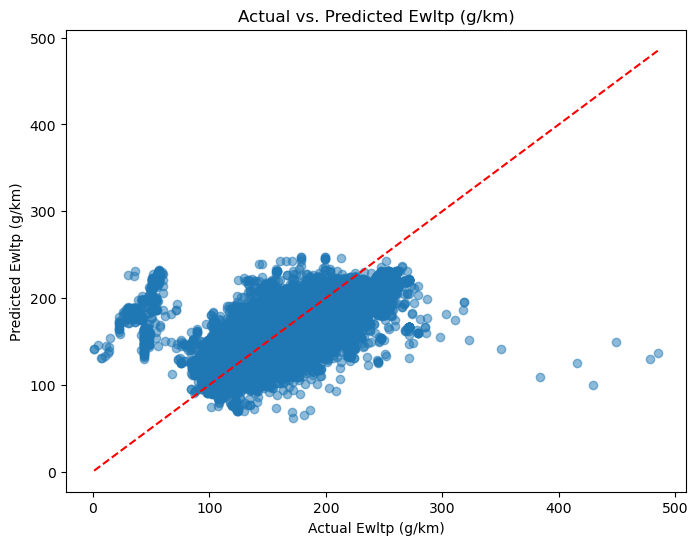

The scatter plot shows the relationship between the actual and predicted values.
The closer the points are to the red dashed diagonal line, the better the predictions are.



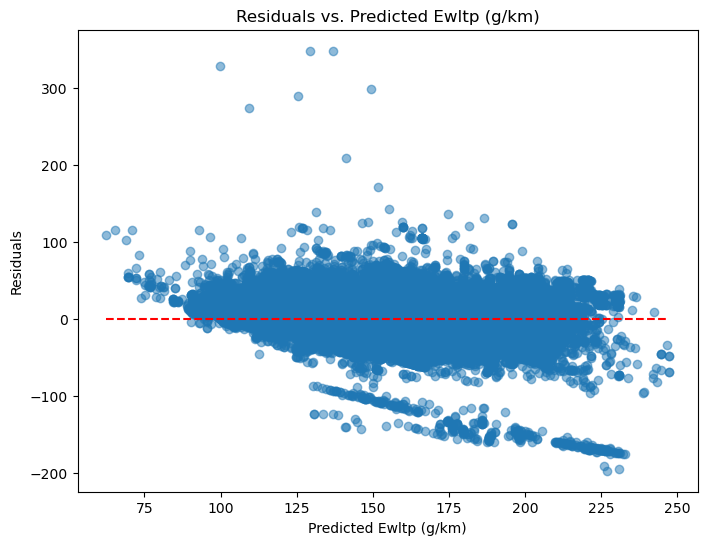

The residuals plot shows the residuals (errors) against the predicted values.
Ideally, the residuals should be randomly dispersed around zero, indicating a good fit.

Interpretation of Results:
The MAE of 9.27 suggests that, on average, the model's predictions are off by 9.27 g/km.
The RMSE of 12.39 indicates that the typical error magnitude is 12.39 g/km.
The R-squared value of 0.69 means that approximately 69.1% of the variance in 'Ewltp (g/km)' is explained by the model.
Overall, these metrics provide an understanding of the model's predictive performance on unseen data.


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Use the model to make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

# Print the evaluation metrics with explanations
print("\nModel Evaluation on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print("MAE measures the average magnitude of the errors in a set of predictions, without considering their direction.")
print("It provides a linear score which means that all the individual differences are weighted equally in the average.\n")

print(f"Mean Squared Error (MSE): {mse:.2f}")
print("MSE measures the average of the squares of the errors—that is, the average squared difference between the estimated values and what is estimated.")
print("It gives higher weight to larger errors, making it more sensitive to outliers.\n")

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print("RMSE is the square root of MSE and provides the error in the same units as the target variable.")
print("It is useful for interpreting the magnitude of the error in the context of the data.\n")

print(f"R-squared (Coefficient of Determination): {r_squared:.2f}")
print("R-squared explains how much of the variance in the target variable is explained by the model.")
print("An R-squared of 1 indicates that the regression predictions perfectly fit the data.\n")

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Ewltp (g/km)')
plt.ylabel('Predicted Ewltp (g/km)')
plt.title('Actual vs. Predicted Ewltp (g/km)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
print("The scatter plot shows the relationship between the actual and predicted values.")
print("The closer the points are to the red dashed diagonal line, the better the predictions are.\n")

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Ewltp (g/km)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Ewltp (g/km)')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
plt.show()
print("The residuals plot shows the residuals (errors) against the predicted values.")
print("Ideally, the residuals should be randomly dispersed around zero, indicating a good fit.\n")

# Additional Interpretation
print("Interpretation of Results:")
print(f"The MAE of {mae:.2f} suggests that, on average, the model's predictions are off by {mae:.2f} g/km.")
print(f"The RMSE of {rmse:.2f} indicates that the typical error magnitude is {rmse:.2f} g/km.")
print(f"The R-squared value of {r_squared:.2f} means that approximately {r_squared*100:.1f}% of the variance in 'Ewltp (g/km)' is explained by the model.")
print("Overall, these metrics provide an understanding of the model's predictive performance on unseen data.")


<Axes: xlabel='ec (cm3)', ylabel='ep (KW)'>

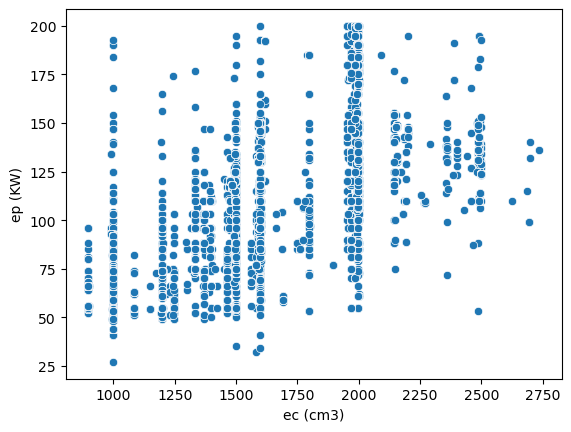

In [14]:
import seaborn as sns


sns.scatterplot(x = "ec (cm3)", y = "ep (KW)", data = df)

C:\Users\onepl\AppData\Local\Temp\ipykernel_18932\102121001.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')


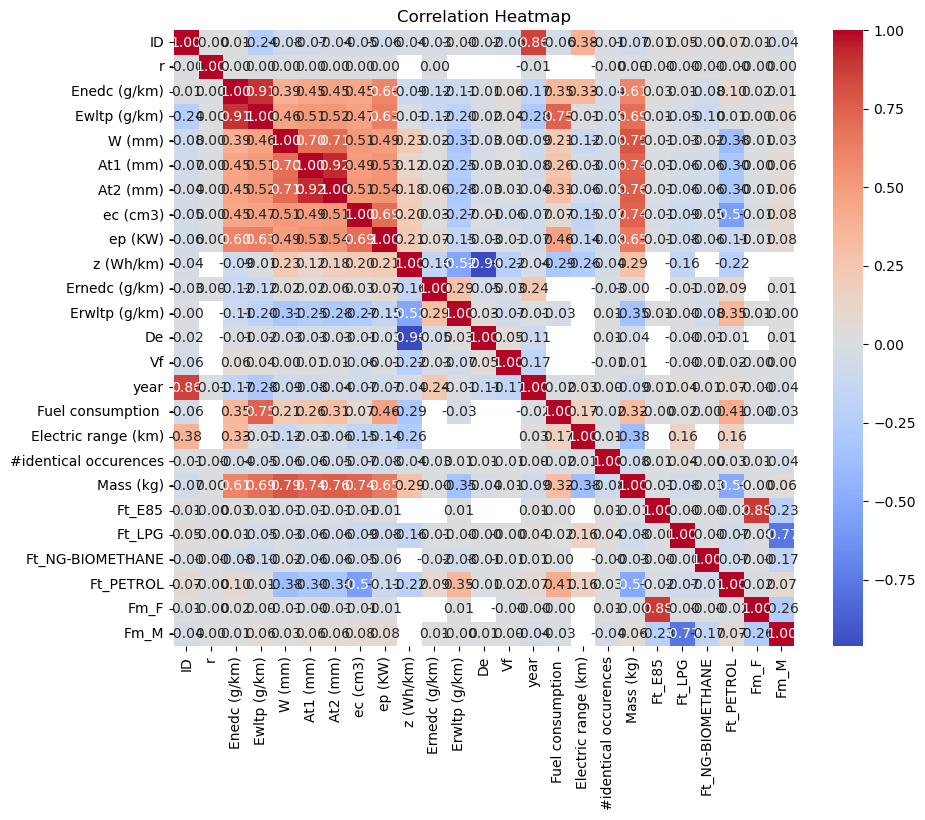

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Add intercept for VIF calculation
X_train_sm = sm.add_constant(X_train_scaled)

vif_data = pd.DataFrame()
vif_data['Feature'] = ['Intercept'] + list(X_train.columns)
vif_data['VIF'] = [variance_inflation_factor(X_train_sm, i) for i in range(X_train_sm.shape[1])]

print(vif_data)


             Feature       VIF
0          Intercept  1.000000
1          Mass (kg)  5.854877
2             W (mm)  2.992001
3           At1 (mm)  7.200090
4           At2 (mm)  7.559979
5           ec (cm3)  4.106737
6            ep (KW)  3.082834
7               Fm_M  3.283527
8             Ft_E85  4.503919
9               Fm_F  4.720514
10         Ft_PETROL  2.262767
11            Ft_LPG  3.009682
12  Ft_NG-BIOMETHANE  1.124523


# Decision Tree


Model Evaluation Metrics Comparison:
      Metric  Linear Regression  Decision Tree
0        MAE       2.235056e+04      83.055382
1        MSE       5.225679e+08    7387.153813
2       RMSE       2.285974e+04      85.948553
3  R-squared      -1.053913e+06     -13.898395


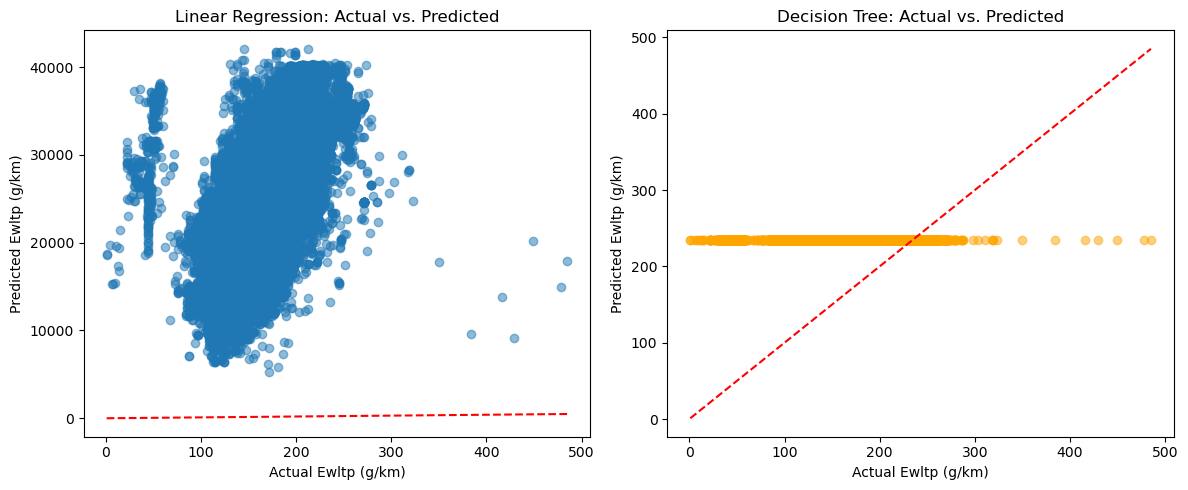

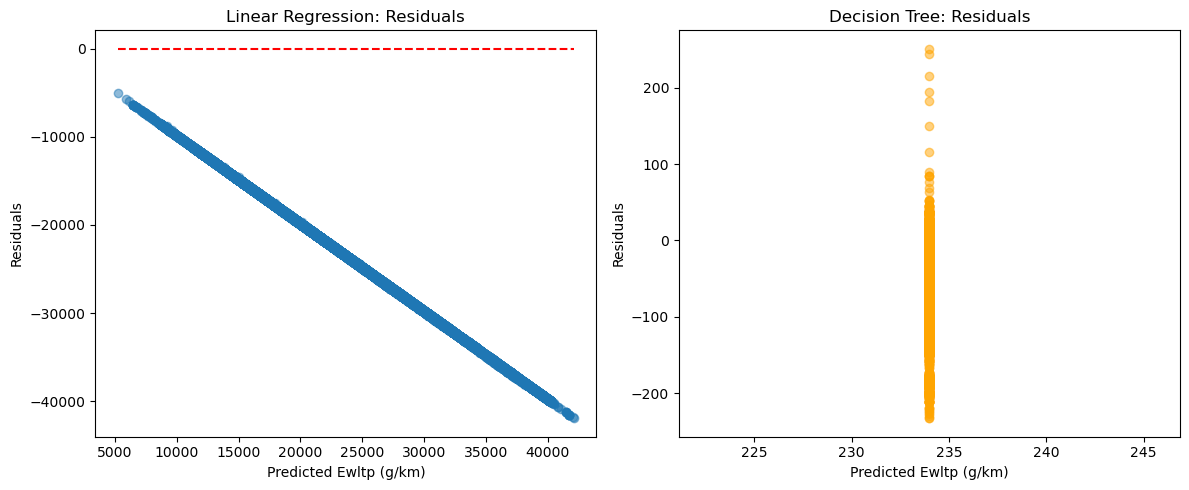


Decision Tree Feature Importances:
1. Mass (kg): 0.5396
2. ep (KW): 0.1304
3. Ft_PETROL: 0.0971
4. W (mm): 0.0898
5. ec (cm3): 0.0728
6. At1 (mm): 0.0402
7. At2 (mm): 0.0259
8. Ft_NG-BIOMETHANE: 0.0025
9. Ft_LPG: 0.0013
10. Fm_F: 0.0002
11. Fm_M: 0.0002
12. Ft_E85: 0.0001


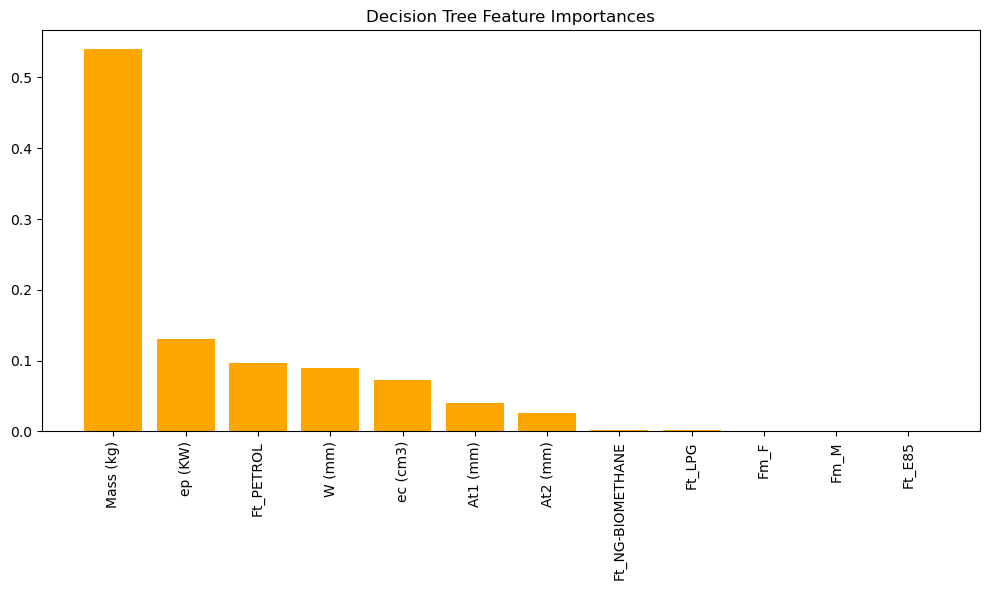

In [17]:
# Import necessary libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
dt_model.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# Calculate evaluation metrics for the Decision Tree model
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r_squared_dt = r2_score(y_test, y_pred_dt)

# For comparison, use the predictions from your Linear Regression model
y_pred_lr = model.predict(X_test)

# Calculate evaluation metrics for the Linear Regression model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r_squared_lr = r2_score(y_test, y_pred_lr)

# Create a DataFrame to compare the evaluation metrics
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R-squared'],
    'Linear Regression': [mae_lr, mse_lr, rmse_lr, r_squared_lr],
    'Decision Tree': [mae_dt, mse_dt, rmse_dt, r_squared_dt]
})

print("\nModel Evaluation Metrics Comparison:")
print(comparison_df)

# Plot predicted vs actual values for both models
plt.figure(figsize=(12, 5))

# Linear Regression plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel('Actual Ewltp (g/km)')
plt.ylabel('Predicted Ewltp (g/km)')
plt.title('Linear Regression: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Decision Tree plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_dt, alpha=0.5, color='orange')
plt.xlabel('Actual Ewltp (g/km)')
plt.ylabel('Predicted Ewltp (g/km)')
plt.title('Decision Tree: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.tight_layout()
plt.show()

# Plot residuals for both models
plt.figure(figsize=(12, 5))

# Linear Regression residuals
plt.subplot(1, 2, 1)
residuals_lr = y_test - y_pred_lr
plt.scatter(y_pred_lr, residuals_lr, alpha=0.5)
plt.xlabel('Predicted Ewltp (g/km)')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residuals')
plt.hlines(y=0, xmin=y_pred_lr.min(), xmax=y_pred_lr.max(), colors='r', linestyles='dashed')

# Decision Tree residuals
plt.subplot(1, 2, 2)
residuals_dt = y_test - y_pred_dt
plt.scatter(y_pred_dt, residuals_dt, alpha=0.5, color='orange')
plt.xlabel('Predicted Ewltp (g/km)')
plt.ylabel('Residuals')
plt.title('Decision Tree: Residuals')
plt.hlines(y=0, xmin=y_pred_dt.min(), xmax=y_pred_dt.max(), colors='r', linestyles='dashed')

plt.tight_layout()
plt.show()

# Feature Importance for Decision Tree
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

# Print feature importances
print("\nDecision Tree Feature Importances:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]}: {importances[indices[f]]:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Decision Tree Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="orange", align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [29]:
l1 = [1,2,3]
l2 = [4,5,6]

In [30]:

workinglist = l1

In [31]:
workinglist.pop()

3

In [33]:
workinglist

[1, 2]

In [34]:
l1

[1, 2]